Starting analysis...
Attempting to load data/metadata.csv...
CORD-19 metadata.csv not found in 'data/' folder. Creating sample data for demonstration.
Dataset shape: (1000, 9)

Columns: ['cord_uid', 'title', 'abstract', 'journal', 'authors', 'publish_time', 'year', 'title_word_count', 'abstract_word_count']

Data types:
 cord_uid               object
title                  object
abstract               object
journal                object
authors                object
publish_time           object
year                    int64
title_word_count        int64
abstract_word_count     int64
dtype: object

Missing values:
 cord_uid               0
title                  0
abstract               0
journal                0
authors                0
publish_time           0
year                   0
title_word_count       0
abstract_word_count    0
dtype: int64

Basic statistics for numerical columns:
       abstract_word_count  title_word_count
count               1000.0            1000.0
mean  

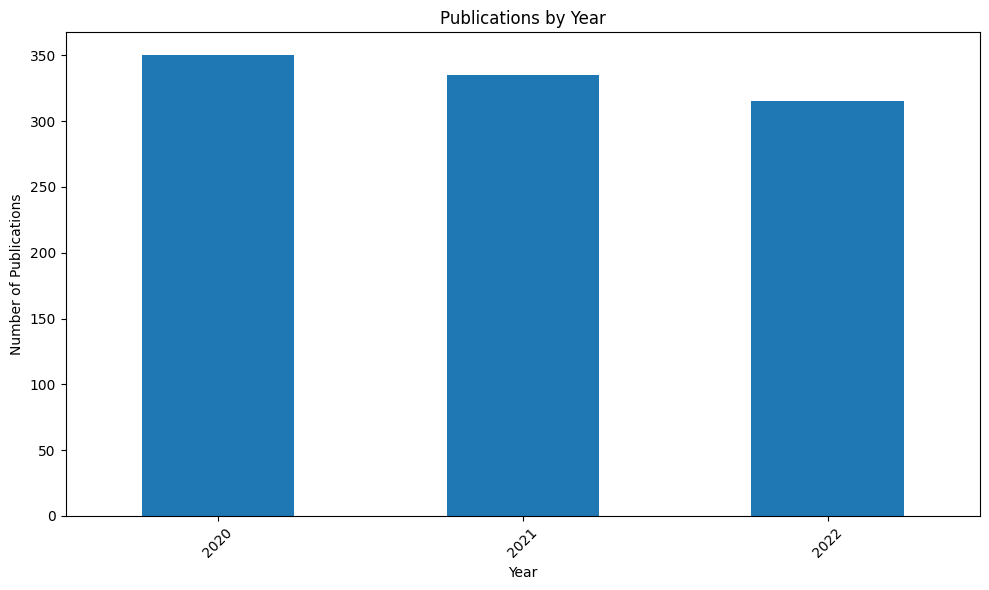

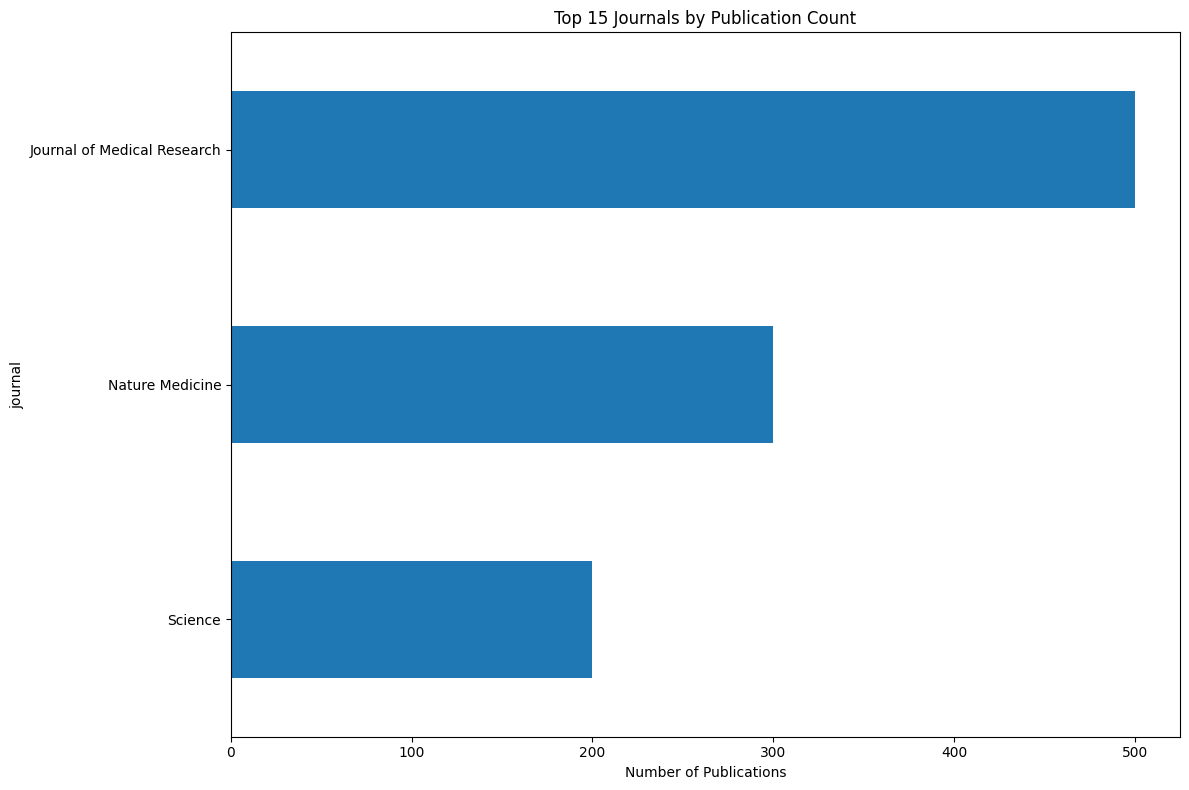

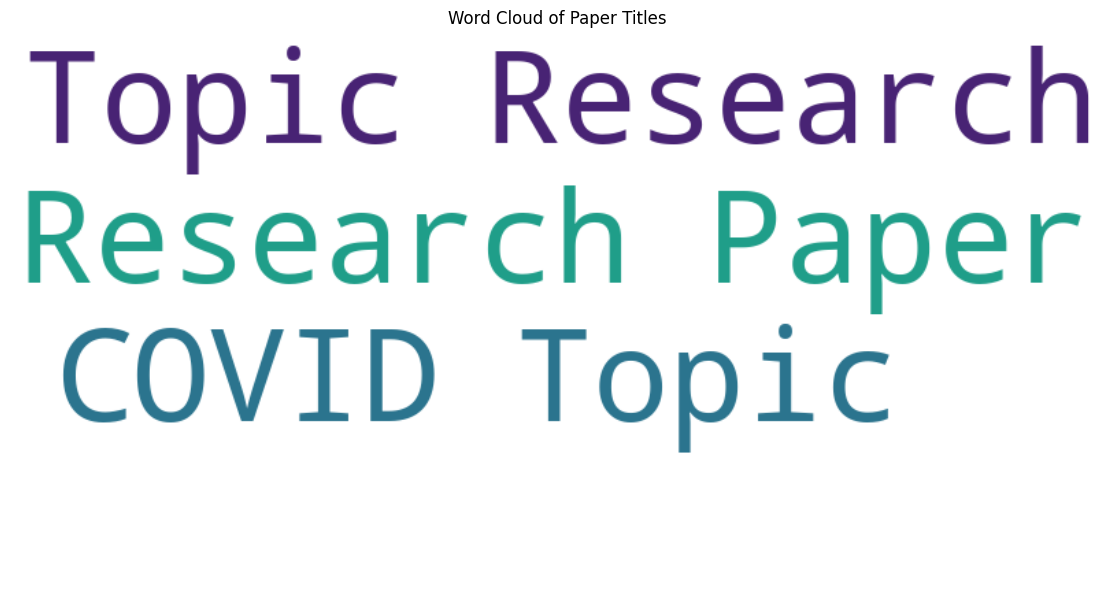

Analysis completed successfully!


In [3]:
# analysis.ipynb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from datetime import datetime

# First, let's create the create_sample_data function that was missing
def create_sample_data():
    """Create sample data for testing when the real file is not available"""
    sample_data = {
        'cord_uid': [f'uid_{i}' for i in range(1000)],
        'title': [f'Research Paper on COVID-19 Topic {i}' for i in range(1000)],
        'abstract': [f'This is an abstract about coronavirus research number {i}. It discusses important findings.' for i in range(1000)],
        'journal': ['Journal of Medical Research'] * 500 + ['Nature Medicine'] * 300 + ['Science'] * 200,
        'authors': [f'Researcher {i}, Co-author {i}' for i in range(1000)],
        'publish_time': [f'202{np.random.randint(0,3)}-{np.random.randint(1,13):02d}-{np.random.randint(1,28):02d}' for _ in range(1000)]
    }
    return pd.DataFrame(sample_data)

# Optimized load_data function
def load_data():
    try:
        # Define columns to load and their data types
        usecols = ['cord_uid', 'title', 'abstract', 'journal', 'publish_time', 'authors']
        dtypes = {
            'cord_uid': 'string',
            'title': 'string',
            'abstract': 'string',
            'journal': 'category',
            'authors': 'string',
            'publish_time': 'string'
        }
        
        # Load in chunks
        chunk_list = []
        chunk_size = 50000
        
        print("Attempting to load data/metadata.csv...")
        for chunk in pd.read_csv("data/metadata.csv", 
                                usecols=usecols, 
                                dtype=dtypes, 
                                chunksize=chunk_size,
                                low_memory=False):
            chunk_list.append(chunk)
        
        df = pd.concat(chunk_list, ignore_index=True)
        print("Loaded CORD-19 metadata with optimized settings!")
        return df
    except FileNotFoundError:
        print("CORD-19 metadata.csv not found in 'data/' folder. Creating sample data for demonstration.")
        return create_sample_data()

# Clean data function
def clean_data(df):
    """Clean and preprocess the data"""
    df_clean = df.copy()
    
    # Handle missing values
    df_clean['title'] = df_clean['title'].fillna('Unknown Title')
    df_clean['abstract'] = df_clean['abstract'].fillna('No abstract available')
    df_clean['journal'] = df_clean['journal'].fillna('Unknown Journal')
    
    # Extract year from publish_time
    def extract_year(date_str):
        try:
            if isinstance(date_str, str):
                if len(date_str) >= 4 and date_str[:4].isdigit():
                    return int(date_str[:4])
        except:
            pass
        return np.nan
    
    df_clean['year'] = df_clean['publish_time'].apply(extract_year)
    
    # Remove rows with invalid years (before 1900 or future years)
    current_year = datetime.now().year
    df_clean = df_clean[(df_clean['year'] >= 1900) & (df_clean['year'] <= current_year)]
    
    # Calculate word counts
    df_clean['title_word_count'] = df_clean['title'].apply(lambda x: len(str(x).split()))
    df_clean['abstract_word_count'] = df_clean['abstract'].apply(lambda x: len(str(x).split()))
    
    return df_clean

# Perform analysis
print("Starting analysis...")
df = load_data()  # This will use the optimized function
df_clean = clean_data(df)

# Basic exploration
print("Dataset shape:", df_clean.shape)
print("\nColumns:", df_clean.columns.tolist())
print("\nData types:\n", df_clean.dtypes)
print("\nMissing values:\n", df_clean.isnull().sum())

# Basic statistics
print("\nBasic statistics for numerical columns:")
print(df_clean[['abstract_word_count', 'title_word_count']].describe())

# Time analysis (if we have year data)
if 'year' in df_clean.columns and not df_clean['year'].isnull().all():
    yearly_counts = df_clean['year'].value_counts().sort_index()
    plt.figure(figsize=(10, 6))
    yearly_counts.plot(kind='bar')
    plt.title('Publications by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Publications')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No valid year data available for time analysis")

# Journal analysis
if 'journal' in df_clean.columns:
    journal_counts = df_clean['journal'].value_counts().head(15)
    plt.figure(figsize=(12, 8))
    journal_counts.plot(kind='barh')
    plt.title('Top 15 Journals by Publication Count')
    plt.xlabel('Number of Publications')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Word cloud of titles
if 'title' in df_clean.columns:
    text = ' '.join(df_clean['title'].dropna().values)
    if text.strip():  # Only create wordcloud if there's text
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Paper Titles')
        plt.tight_layout()
        plt.show()
    else:
        print("No title data available for word cloud")

print("Analysis completed successfully!")